In [1]:
import torch
from torch import nn
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import BartTokenizer, BartModel

C:\Users\praveenchakra.bh\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("datasets/spam.csv", encoding='ISO-8859-1')
df.head(3)

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [3]:
df["labels"] = df['class'] == "spam"
df["labels"]

0       False
1       False
2        True
3       False
4       False
        ...  
5567     True
5568    False
5569    False
5570    False
5571    False
Name: labels, Length: 5572, dtype: bool

In [4]:
df.head()

,class,text,labels
0,ham,"Go until jurong point, crazy.. Available only ...",False
1,ham,Ok lar... Joking wif u oni...,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,ham,U dun say so early hor... U c already then say...,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",False


In [5]:
df.drop("class", axis=1, inplace=True)
df.head()

,text,labels
0,"Go until jurong point, crazy.. Available only ...",False
1,Ok lar... Joking wif u oni...,False
2,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,U dun say so early hor... U c already then say...,False
4,"Nah I don't think he goes to usf, he lives aro...",False


In [6]:
df_train = df.sample(frac=0.8, random_state=42)
df_test = df.drop(df_train.index)

In [7]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
embed_model = BartModel.from_pretrained("facebook/bart-base")

In [8]:
x_train = []
messages = df_train["text"].values
for message in tqdm(messages):
    tokenized_output = tokenizer([message], padding=True, max_length=128, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embed_model.eval()
        outputs = embed_model(**tokenized_output)
        embedds = outputs.last_hidden_state.mean(dim=1)[0]
        x_train.append(embedds)

100%|██████████████████| 4458/4458 [28:40<00:00,  2.59it/s]


In [9]:
x_train = torch.stack(x_train)
print(x_train.shape)

torch.Size([4458, 768])


In [14]:
y_train = torch.tensor(df_train["labels"], dtype= torch.float32).reshape((-1, 1))

In [15]:
len(y_train)

4458

In [12]:
model = nn.Linear(768, 1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [16]:
losses = []
for i in tqdm(range(10000)):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = loss_fn(outputs, y_train)
    if i % 100 == 0:
        losses.append(loss.item())
    loss.backward()
    optimizer.step()

100%|███████████████| 10000/10000 [00:13<00:00, 762.73it/s]


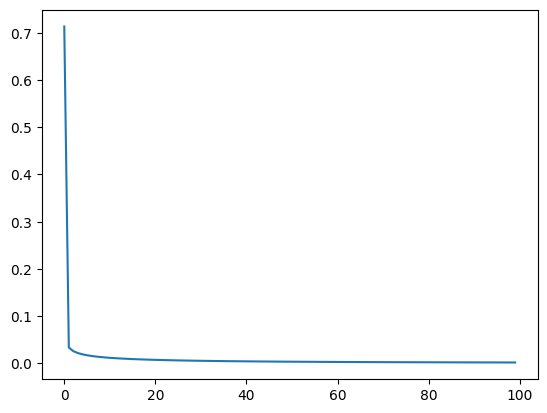

In [17]:
plt.plot(losses)
plt.show()

In [18]:
test_x = []
messages = df_test["text"].values
for message in tqdm(messages):
    tokenized_output = tokenizer([message], padding=True, max_length=128, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embed_model.eval()
        outputs = embed_model(**tokenized_output)
        embedds = outputs.last_hidden_state.mean(dim=1)[0]
        test_x.append(embedds)

100%|██████████████████| 1114/1114 [00:53<00:00, 20.68it/s]


In [19]:
test_x = torch.stack(test_x)

In [20]:
test_y = torch.tensor(df_test["labels"].values, dtype= torch.float32).reshape((-1, 1))

In [21]:
model.eval()
with torch.no_grad():
    y_pred = nn.functional.sigmoid(model(test_x)) > 0.15
    y_pred = y_pred.reshape(-1, 1).type(torch.float32) 
    accuracy = (y_pred == test_y).type(torch.float32).mean()
    sensitivity = (y_pred[test_y == 1] == test_y[test_y == 1]).type(torch.float32).mean()
    specificity = (y_pred[test_y == 0] == test_y[test_y == 0]).type(torch.float32).mean()
    precision = (y_pred[y_pred == 1] == test_y[y_pred == 1]).type(torch.float32).mean()
    print(f"Accuracy: {accuracy.item()}, Sensitivity: {sensitivity.item()}, Specificity: {specificity.item()}, Precision: {precision.item()}")

Accuracy: 0.9901256561279297, Sensitivity: 0.9490445852279663, Specificity: 0.9968652129173279, Precision: 0.9802631735801697


In [25]:
text = "Worst offer period, don't buy the phones now"
tokenized_output = tokenizer([text], padding=True, max_length=128, truncation=True, return_tensors="pt")
with torch.no_grad():
    embed_model.eval()
    outputs = embed_model(**tokenized_output)
    embedds = outputs.last_hidden_state.mean(dim=1)
    y = nn.functional.sigmoid(model(embedds))
    result = "Ham" if y[0].item() > 0.2 else "Spam"
    print(f"{result} : {y[0].item()}")

Spam : 0.021224234253168106


In [26]:
text = "Hurry up!, this is the best deal ever"
tokenized_output = tokenizer([text], padding=True, max_length=128, truncation=True, return_tensors="pt")
with torch.no_grad():
    embed_model.eval()
    outputs = embed_model(**tokenized_output)
    embedds = outputs.last_hidden_state.mean(dim=1)
    y = nn.functional.sigmoid(model(embedds))
    result = "Ham" if y[0].item() > 0.2 else "Spam"
    print(f"{result} : {y[0].item()}")

Ham : 0.2938457429409027


In [27]:
text = "Exciting Deal you need to see, buy iphone16 pro at lowest rate"
tokenized_output = tokenizer([text], padding=True, max_length=128, truncation=True, return_tensors="pt")
with torch.no_grad():
    embed_model.eval()
    outputs = embed_model(**tokenized_output)
    embedds = outputs.last_hidden_state.mean(dim=1)
    y = nn.functional.sigmoid(model(embedds))
    result = "Ham" if y[0].item() > 0.2 else "Spam"
    print(f"{result} : {y[0].item()}")

Ham : 0.9825382232666016
